In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import string
import time
import re
import nltk
# Import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\danto\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    #print(tag_dict.get(tag, wordnet.NOUN))
    return tag_dict.get(tag, wordnet.NOUN)

pattern = re.compile("【|】|\[|\]")

# Initalize TweetTokenizer
tt = TweetTokenizer()

# English stop words
english_stops = stopwords.words('english')

printable = set(string.printable)

# Instantiate the WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def editString(title):
    title = pattern.sub("|",title)                             # replace square brackets with |
    title = "".join(filter(lambda x: x in printable, title))   # remove non printable characters
    #print(title)
    tokens = tt.tokenize(text=title)
    
    # Convert the tokens into lowercase: lower_tokens, indicate if capital
    tokens_edited = [t.lower() + " [&CAP] " if (t.upper() == t and t.isalpha() and len(t) > 1) else t.lower() for t in tokens ]
    #print(tokens_edited)
    # Remove all stop words: no_stops
    no_stops = [t for t in tokens_edited if t not in english_stops]
    #print(no_stops)
    # Lemmatize all tokens into a new list: lemmatized
    lemmatized = [wordnet_lemmatizer.lemmatize(t, get_wordnet_pos(t)) for t in no_stops]
    #print(lemmatized)
    return " ".join(lemmatized)



In [76]:
raw_df_test = pd.read_csv("metadata_test.csv")
raw_df_train = pd.read_csv("metadata_train.csv")
raw_df_train_2 = pd.read_csv("metadata_b0.csv")
raw_df_train = pd.concat([raw_df_train, raw_df_train_2.iloc[:,1:]],axis=1)

def process_df(raw_df):
    df = raw_df.T.copy()
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header.rename("") #set the header row as the df header
    df.drop(columns=["likes","dislikes","views","desc","id"],inplace=True)
    print(df.clickbait)
    #df.likes = pd.to_numeric(df.likes.astype(str).str.replace(',','').str.replace("likes",""), errors='coerce').fillna(0).astype(int)
    #df.dislikes = pd.to_numeric(df.dislikes.astype(str).str.replace(',','').str.replace("dislikes",""), errors='coerce').fillna(0).astype(int)
    #df.views = pd.to_numeric(df.views.astype(str).str.replace(',','').str.replace("views",""), errors='coerce').fillna(0).astype(int)
    df.clickbait = df.clickbait.astype(int)
    df.title = df.title.apply(editString)
    df.reset_index(drop=True, inplace=True)
    return df



t = time.time()
df_test = process_df(raw_df_test)
df_train = process_df(raw_df_train)
print(time.time()-t)


0      0
1      0
2      1
3      1
4      0
      ..
165    0
166    0
167    0
168    0
169    1
Name: clickbait, Length: 170, dtype: object
0      0
1      1
2      0
3      1
4      0
      ..
165    0
166    1
167    0
168    0
169    1
Name: clickbait, Length: 9911, dtype: object
65.37210273742676


In [36]:
def load_dataset_from_df(df):
    #print(df)
    target = df['clickbait']
    values = df['title']
    dataset = tf.data.Dataset.from_tensor_slices((values, target))
    return dataset

In [113]:
batch_size = 32
validation_split = 0.2
raw_fulltrain_ds = load_dataset_from_df(df_train[4000:])
raw_fulltrain_ds.shuffle(buffer_size = 10000, seed=1337)
print("Loaded full train dataset")
train_size = int((1-validation_split) * int(tf.data.experimental.cardinality(raw_fulltrain_ds)))
raw_train_ds = raw_fulltrain_ds.take(train_size).batch(batch_size)
print("Loaded train dataset")
raw_val_ds = raw_fulltrain_ds.skip(train_size).batch(batch_size)
print("Loaded validation dataset")
raw_test_ds = load_dataset_from_df(df_test).batch(batch_size)
print("Loaded test dataset")
raw_fulltrain_ds = raw_fulltrain_ds.batch(batch_size)
print("Batched full train dataset")

Loaded full train dataset
Loaded train dataset
Loaded validation dataset
Loaded test dataset
Batched full train dataset


In [78]:
print(
    "Number of batches in raw_train_ds: %d"
    % tf.data.experimental.cardinality(raw_train_ds)
)
print(
    "Number of batches in raw_val_ds: %d" % tf.data.experimental.cardinality(raw_val_ds)
)
print(
    "Number of batches in raw_test_ds: %d"
    % tf.data.experimental.cardinality(raw_test_ds)
)

Number of batches in raw_train_ds: 991
Number of batches in raw_val_ds: 248
Number of batches in raw_test_ds: 22


In [79]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b"veteran ' voice 2020 : general joseph votel , u . . army ( ret . )"
0
b'make tandoori chicken'
1
b'25 airbag rainbow explosion 4k - slow mo guy'
0
b'hunt secret [&CAP]  megalodon [&CAP]  boss [&CAP]  minecraft !'
1
b'maroon 5 - wanna know ( behind scene )'
0


In [115]:
# Model constants.
max_features = 10000
embedding_dim = 32
sequence_length = 300

# Now that we have our custom standardization, we can instantiate our text
# vectorization layer. We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
vectorize_layer = TextVectorization(
    standardize = None,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Now that the vocab layer has been created, call `adapt` on a text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.

# Let's make a text-only dataset (no labels):
text_ds = raw_train_ds.map(lambda x, y: x)
text_dss = raw_fulltrain_ds.map(lambda x, y: x)
# Let's call `adapt`:
vectorize_layer.adapt(text_dss)


In [81]:
print(vectorize_layer.get_vocabulary())
print(len(vectorize_layer.get_vocabulary()))

['', '[UNK]', '[&CAP]', '!', '|', '-', '(', ')', ':', '*', ',', 'fortnite', '?', '.', 'new', 'challenge', '...', 'faze', '$', '5', '..', 'v', 'make', 'get', '&', '2021', 'house', 'kid', '2', 'star', 'show', 'full', 'slow', 'crash', '"', 'prank', 'course', '/', 'tutorial', "'", 'hq', 'live', 'shop', 'item', 'album', 'wtt', 'doha', 'contender', 'my', 'official', 'video', 'to', 'big', 'the', 'highlight', 'world', 'tonight', 'in', 'mo', 'life', 'guy', 'game', 'ft', 'review', '1', 'roblox', 'clip', 'day', 'minecraft', 'maroon', 'go', 'play', 'car', 'battle', 'first', 'episode', 'ever', 'million', 'ryan', '#', 'best', '3', 'now', 'tik', 'future', 'try', 'trailer', 'google', 'girlfriend', '2020', 'jimmy', 'english', 'sub', 'win', 'royale', '10', 'mashable', '24', 'bad', 'like', '4', 'real', 'history', 'theory', 'fallon', 'bang', 'people', 'inside', 'time', '10,000', 'gta', 'single', 'react', 'beginner', '6', 'you', 'last', 'thing', 'one', 'look', 'right', 'not', 'blink', 'out', 'pro', 'year',

In [116]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)
fulltrain_ds = raw_fulltrain_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=50)
val_ds = val_ds.cache().prefetch(buffer_size=50)
test_ds = test_ds.cache().prefetch(buffer_size=50)
fulltrain_ds = fulltrain_ds.cache().prefetch(buffer_size=50)

In [83]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

[ 661   39  623   89    8 2448 4148 5079   10  133   13   13 1819    6
 2847   13    7    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [117]:
import tensorflow.keras.backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [131]:
from tensorflow.keras import layers

# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.7)(x)

# Conv1D + global max pooling
x = layers.Conv1D(256, 7, padding="valid", activation="relu", strides=2)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=2)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc", precision_m, recall_m, f1_m])
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_15 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
dropout_30 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, None, 256)         57600     
_________________________________________________________________
conv1d_31 (Conv1D)           (None, None, 128)         229504    
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               330

In [132]:
epochs = 5

# Fit the model using the full train and test datasets.
#history = model.fit(fulltrain_ds, validation_data=test_ds, epochs=epochs)

# Fit the model using the train and validation datasets.
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Fit the model using the full train and test datasets.
#history = model.fit(test_ds, validation_data=train_ds, epochs=epochs)

Epoch 1/5
148/148 [==============================] - 15s 99ms/step - loss: 0.6576 - acc: 0.5968 - precision_m: 0.2676 - recall_m: 0.1064 - f1_m: 0.1339 - val_loss: 0.3625 - val_acc: 0.8369 - val_precision_m: 0.7601 - val_recall_m: 0.8672 - val_f1_m: 0.8035
Epoch 2/5
148/148 [==============================] - 16s 110ms/step - loss: 0.3186 - acc: 0.8621 - precision_m: 0.8672 - recall_m: 0.8141 - f1_m: 0.8341 - val_loss: 0.2972 - val_acc: 0.8732 - val_precision_m: 0.8030 - val_recall_m: 0.8927 - val_f1_m: 0.8383
Epoch 3/5
148/148 [==============================] - 16s 109ms/step - loss: 0.1992 - acc: 0.9172 - precision_m: 0.9084 - recall_m: 0.9092 - f1_m: 0.9055 - val_loss: 0.2804 - val_acc: 0.8893 - val_precision_m: 0.8492 - val_recall_m: 0.8579 - val_f1_m: 0.8475
Epoch 4/5
148/148 [==============================] - 17s 113ms/step - loss: 0.1472 - acc: 0.9427 - precision_m: 0.9443 - recall_m: 0.9280 - f1_m: 0.9338 - val_loss: 0.3007 - val_acc: 0.8884 - val_precision_m: 0.8398 - val_recal

In [100]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'acc', 'precision_m', 'recall_m', 'f1_m', 'val_loss', 'val_acc', 'val_precision_m', 'val_recall_m', 'val_f1_m'])

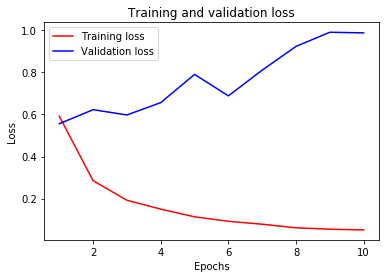

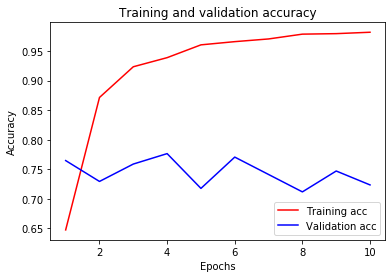

In [125]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [126]:
model.evaluate(test_ds)

6/6 [==============================] - 0s 31ms/step - loss: 0.6312 - acc: 0.7706 - precision_m: 0.5306 - recall_m: 0.6873 - f1_m: 0.5805


[0.6311905980110168,
 0.770588219165802,
 0.5305555462837219,
 0.6872895359992981,
 0.5804733633995056]

In [127]:
model.evaluate(train_ds)

148/148 [==============================] - 4s 24ms/step - loss: 0.0483 - acc: 0.9835 - precision_m: 0.9822 - recall_m: 0.9812 - f1_m: 0.9811


[0.048325467854738235,
 0.9835025668144226,
 0.9822041392326355,
 0.9812341928482056,
 0.9810900092124939]

In [128]:
model.evaluate(val_ds)

37/37 [==============================] - 1s 22ms/step - loss: 0.0607 - acc: 0.9848 - precision_m: 0.9777 - recall_m: 0.9818 - f1_m: 0.9787


[0.06072932109236717,
 0.9847844243049622,
 0.9776589870452881,
 0.9817966818809509,
 0.9787176251411438]